In [49]:
#hide
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [50]:
#hide
from fastbook import *
from fastai.vision.widgets import *

In [51]:
key = os.environ.get('AZURE_SEARCH_KEY', 'c5efaabeaee847d19423ec589baeb4f6')

In [52]:
search_images_bing

<function fastbook.search_images_bing(key, term, min_sz=128, max_images=150)>

In [53]:
results = search_images_bing(key, 'suiriri')
ims = results.attrgot('contentUrl')
len(ims)

150

In [54]:
tipos_passaros = 'suiriri-cavaleiro', 'suiriri-de-garganta-branca', 'suiriri'
path = Path('passaros-suiriri')

In [55]:
if not path.exists():
    path.mkdir()
    for o in tipos_passaros:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images_bing(key, f'suiriri {o}')
        download_images(dest, urls=results.attrgot('contentUrl'))

In [56]:
fns = get_image_files(path)
fns

(#443) [Path('passaros-suiriri/suiriri-de-garganta-branca/00000047.jpg'),Path('passaros-suiriri/suiriri-de-garganta-branca/00000055.jpg'),Path('passaros-suiriri/suiriri-de-garganta-branca/00000126.JPG'),Path('passaros-suiriri/suiriri-de-garganta-branca/00000107.jpg'),Path('passaros-suiriri/suiriri-de-garganta-branca/00000036.jpg'),Path('passaros-suiriri/suiriri-de-garganta-branca/00000030.jpg'),Path('passaros-suiriri/suiriri-de-garganta-branca/00000097.jpg'),Path('passaros-suiriri/suiriri-de-garganta-branca/00000148.jpg'),Path('passaros-suiriri/suiriri-de-garganta-branca/00000110.jpg'),Path('passaros-suiriri/suiriri-de-garganta-branca/00000112.jpg')...]

In [57]:
failed = verify_images(fns)
failed

(#0) []

In [58]:
failed.map(Path.unlink);

In [59]:
passaros = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

In [60]:
dls = passaros.dataloaders(path)

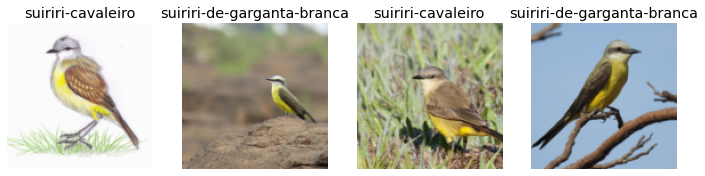

In [61]:
dls.valid.show_batch(max_n=4, nrows=1)

In [62]:
passaros = passaros.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = passaros.dataloaders(path)

In [63]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.773348,1.098482,0.431818,00:07


epoch,train_loss,valid_loss,error_rate,time
0,1.376737,0.740516,0.329545,00:08
1,1.201240,0.681284,0.284091,00:08
2,1.131739,0.759064,0.329545,00:07
3,1.023136,0.807373,0.318182,00:07


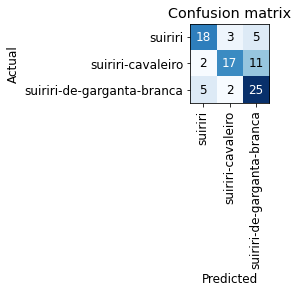

In [64]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

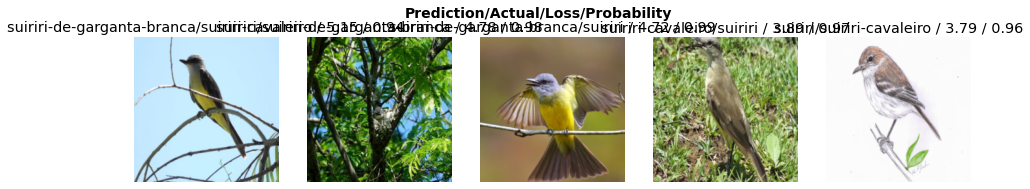

In [65]:
interp.plot_top_losses(5, nrows=1)

In [66]:
#hide_output
cleaner = ImageClassifierCleaner(learn)
cleaner

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f6cdaae9c20>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
Exception ignored in:   File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'<function _MultiProcessingDataLoaderIter.__del__ at 0x7f6cdaae9c20>

Traceback (most recent call last):
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f6cdaae9c20>  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    AssertionErrorself._shutdown_workers(): 
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320,

In [67]:
#hide
#Nesta célula, as imagens classificadas para outras pastas no bloco anterior, são movidas para as pastas corrigidas
name = 150
for idx, cat in cleaner.change():
    path_origem = str(cleaner.fns[idx])
    path_destino = path/cat/f"{name}.{path_origem.split('.')[-1]}" #aqui, é para não ocorrer repetição de nome entre as imagens
    
    shutil.move(path_origem, path_destino) #comando para mudar as imagens de pasta
    name += 1


In [68]:
learn.export('suiriri.pkl')

In [77]:
#hide
!pip install voila
!jupyter serverextension enable --sys-prefix voila 

     |████████████████████████████████| 1.7 MB 16.4 MB/s eta 0:00:01
     |████████████████████████████████| 111 kB 28.5 MB/s eta 0:00:01
     |████████████████████████████████| 558 kB 35.0 MB/s eta 0:00:01
     |████████████████████████████████| 397 kB 37.3 MB/s eta 0:00:01
     |████████████████████████████████| 71 kB 14.1 MB/s eta 0:00:01
     |████████████████████████████████| 79 kB 10.1 MB/s eta 0:00:01
  Attempting uninstall: nbconvert
    Found existing installation: nbconvert 5.6.1
    Uninstalling nbconvert-5.6.1:
      Successfully uninstalled nbconvert-5.6.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
nbdev 1.1.23 requires nbconvert<6, but you have nbconvert 6.4.2 which is incompatible.
Enabling: voila
- Writing config: /opt/conda/etc/jupyter
    - Validating...
      voila 0.3.1 OK


In [69]:
path = Path()
path.ls(file_exts='.pkl')

(#2) [Path('export_suiriri.pkl'),Path('suiriri.pkl')]

In [70]:
learn_inf = load_learner(path/'suiriri.pkl')

In [71]:
learn_inf.predict('passaros-suiriri/suiriri-cavaleiro/00000001.jpg')

('suiriri-cavaleiro', TensorBase(1), TensorBase([0.0843, 0.7613, 0.1544]))

In [72]:
learn_inf.dls.vocab

['suiriri', 'suiriri-cavaleiro', 'suiriri-de-garganta-branca']

In [ ]:
CRIANDO OS BOTÕES DE UPLOAD E CLASSIFY numa Vbox

In [73]:
pred,pred_idx,probs = learn_inf.predict(img)

In [74]:
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Predição: {pred}; Probabilidade: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)

In [75]:
#hide
#Putting back btn_upload to a widget for next cell
btn_upload = widgets.FileUpload()

In [76]:
#hide_output
VBox([widgets.Label('Selecione sua suiriri!'), 
      btn_upload, btn_run, out_pl, lbl_pred])